In [205]:
'''
Dependencies
'''
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from rutils import *
from pyaldata import *
import re
from scipy import stats
from tqdm import tqdm as pbar
import itertools

'''
Plotting aesthetics
'''
sns.set_style('white')
cmap = sns.light_palette(color='#083ba7', as_cmap=True)
div_cmap = sns.diverging_palette(250, 150, as_cmap=True)
cs = ['#083ba7', '#1E2E36', '#6FA374', '#E7C85F', '#FB4A08', '#232625', '#CA592F', '#648C42', '#EE464A', '#727475']

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=cs)
np.set_printoptions(suppress=True, precision=3)
sns.set_context('notebook', font_scale = 1.2, rc = {'lines.linewidth': 2, 'legend.fontsize': 14, 'legend.handlelength': 1.3})

'''
Magic commands
'''
%config InlineBackend.figure_format = 'retina'

In [206]:
'''
Note: VR sessions have typically more neurons than CF sessions
'''

sessions_vr = [
 'Chewie_CO_VR_2016-09-09.mat',
 'Chewie_CO_VR_2016-09-12.mat',
 'Chewie_CO_VR_2016-09-14.mat',
 'Chewie_CO_VR_2016-10-06.mat',
 'Mihili_CO_VR_2014-03-03.mat',
 'Mihili_CO_VR_2014-03-04.mat',
 'Mihili_CO_VR_2014-03-06.mat',
]

sessions_cf = [
    'Chewie_CO_FF_2016-09-15.mat',
    'Chewie_CO_FF_2016-09-21.mat',
    'Chewie_CO_FF_2016-10-05.mat',
    'Chewie_CO_FF_2016-10-07.mat',
    'Mihili_CO_FF_2014-02-03.mat',
    'Mihili_CO_FF_2014-02-17.mat',
    'Mihili_CO_FF_2014-02-18.mat',
    'Mihili_CO_FF_2014-03-07.mat'
]

In [228]:
warnings.filterwarnings('ignore')

'''
Select session
'''
session = sessions_vr[0]


'''
Preprocess
'''
df = mat2dataframe('/Users/Daphne/Data/' + session, shift_idx_fields=True)
# Get the date of the session and monkey name for plotting later
date = '-'.join(re.findall('[0-9]+', session))
monkey = session[:6]

# Preprocess
td = combine_time_bins(df, n_bins=3)

td = remove_low_firing_neurons(td, signal='M1_spikes',  threshold=0)
td = remove_low_firing_neurons(td, signal='PMd_spikes', threshold=0)

td = transform_signal(td, signals='M1_spikes',  transformations='sqrt')
td = transform_signal(td, signals='PMd_spikes', transformations='sqrt')

td = merge_signals(td, ['M1_spikes', 'PMd_spikes'], 'both_spikes')

td = add_firing_rates(td, 'smooth', std=0.05)

# Concatenate trial-data column wise
X_emp_rates  = np.concatenate(td['both_rates'].values, axis=0).T
X_emp_spikes = np.concatenate(td['both_spikes'].values, axis=0).T

In [231]:
X_emp_rates.shape # neurons x timepoints

(246, 114364)

### Display spike trains and firing rates

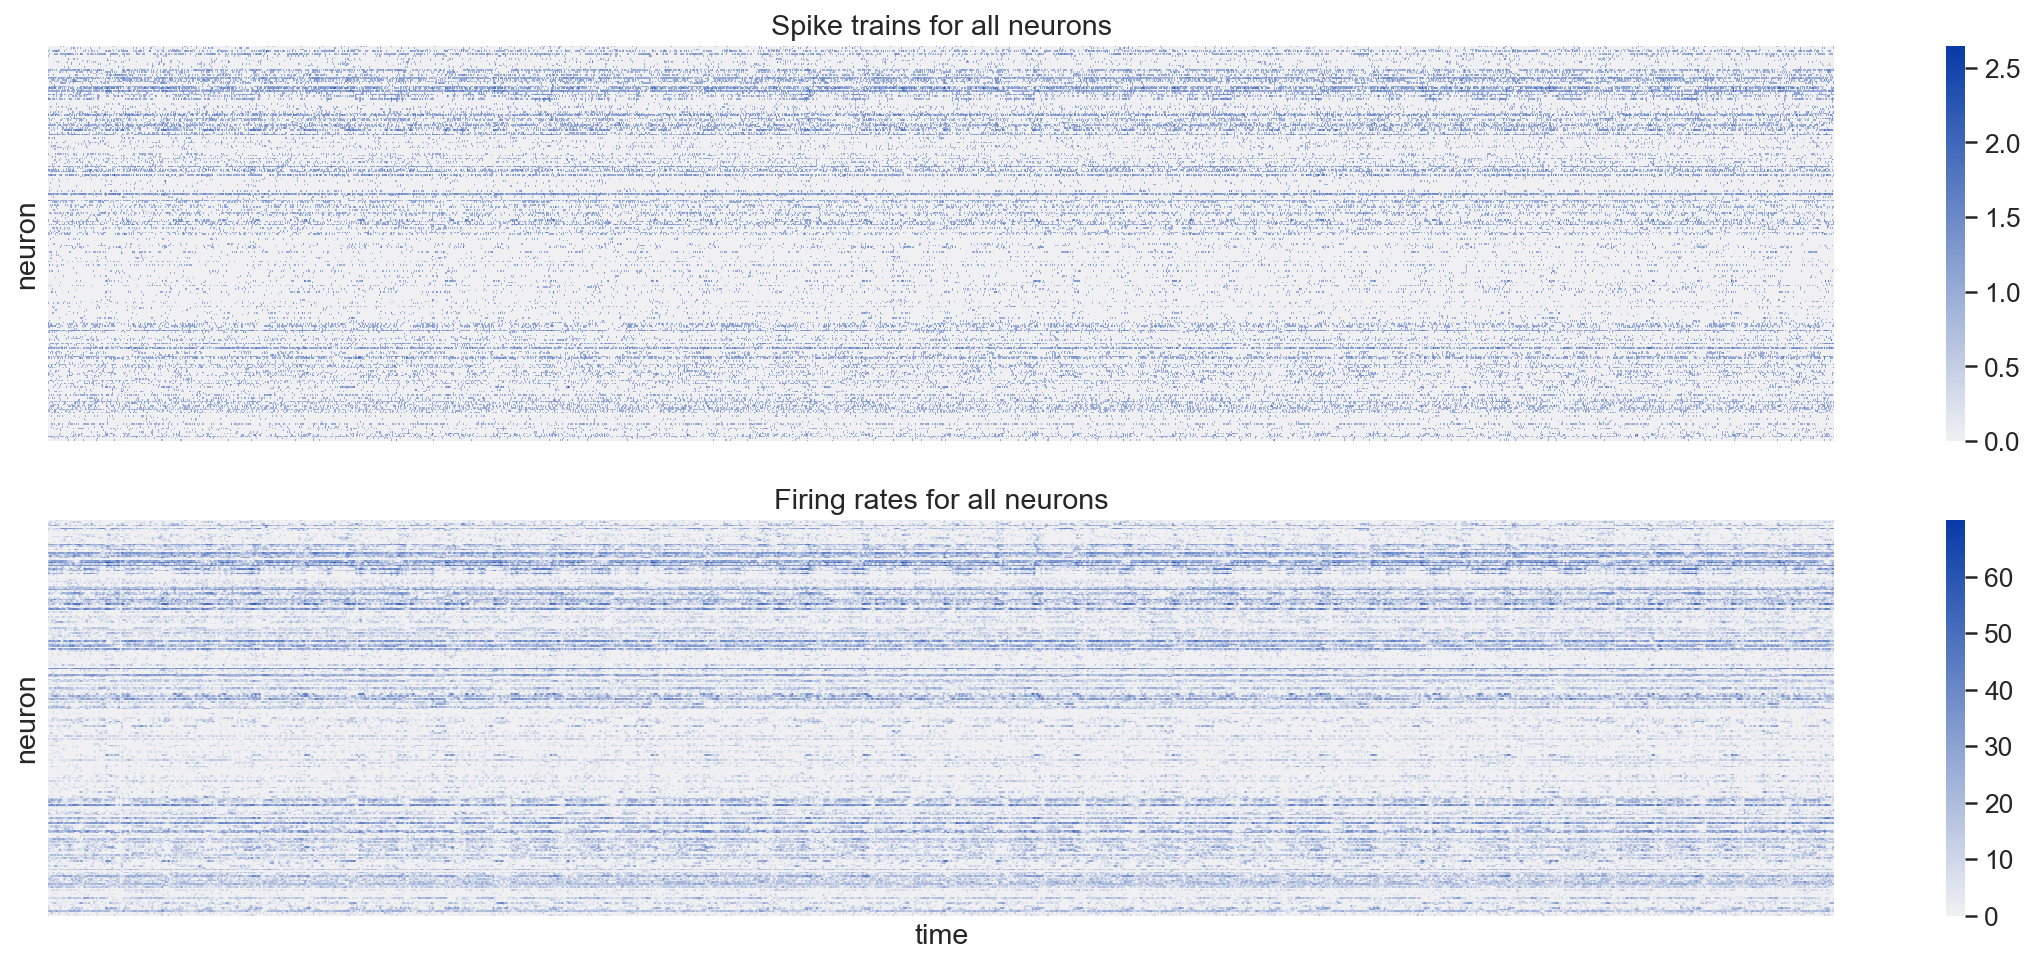

In [232]:
fig, axs = plt.subplots(2, 1, figsize=(20, 8))

axs[0].set_title('Spike trains for all neurons')
sns.heatmap(X_emp_spikes[:, :5000], cmap=cmap, xticklabels=False, yticklabels=False, ax=axs[0])
axs[0].set_ylabel('neuron')

axs[1].set_title('Firing rates for all neurons')
sns.heatmap(X_emp_rates[:, :5000], cmap=cmap, xticklabels=False, yticklabels=False, ax=axs[1])
axs[1].set_ylabel('neuron')
axs[1].set_xlabel('time');

### Investigate spike patterns

- Group spike patterns by distance (color by distance)?
- Display: are they similar? Should they be aligned?

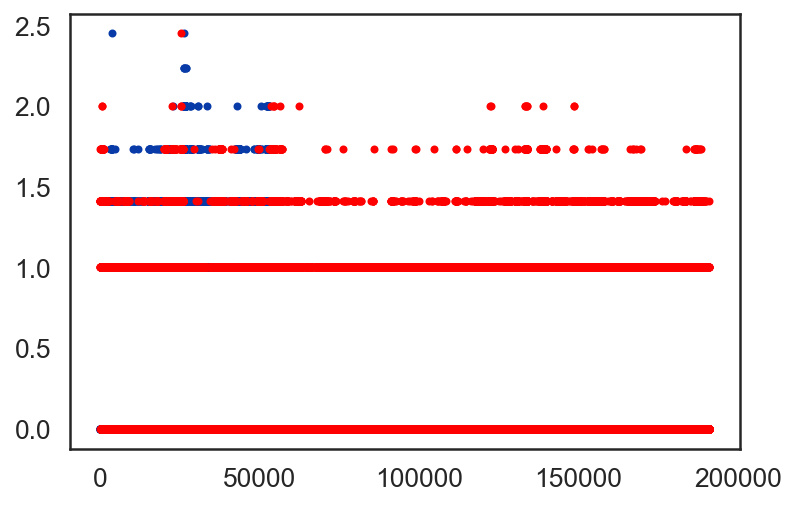

In [233]:
'''
Select a trial
'''

trials = 1000

# Concatenate trial-wise and get in shape (neurons, timepoints)
X_emp_m1 = np.concatenate(td.M1_spikes, axis=0).T
X_emp_pmd = np.concatenate(td.PMd_spikes, axis=0).T

m1_spatterns = X_emp_m1[:, :trials]
pmd_spatterns = X_emp_pmd[:, :trials]

# Check values in spatterns (they have been smoothened)
plt.plot(m1_spatterns.flatten(), '.')
plt.plot(pmd_spatterns.flatten(), '.r');

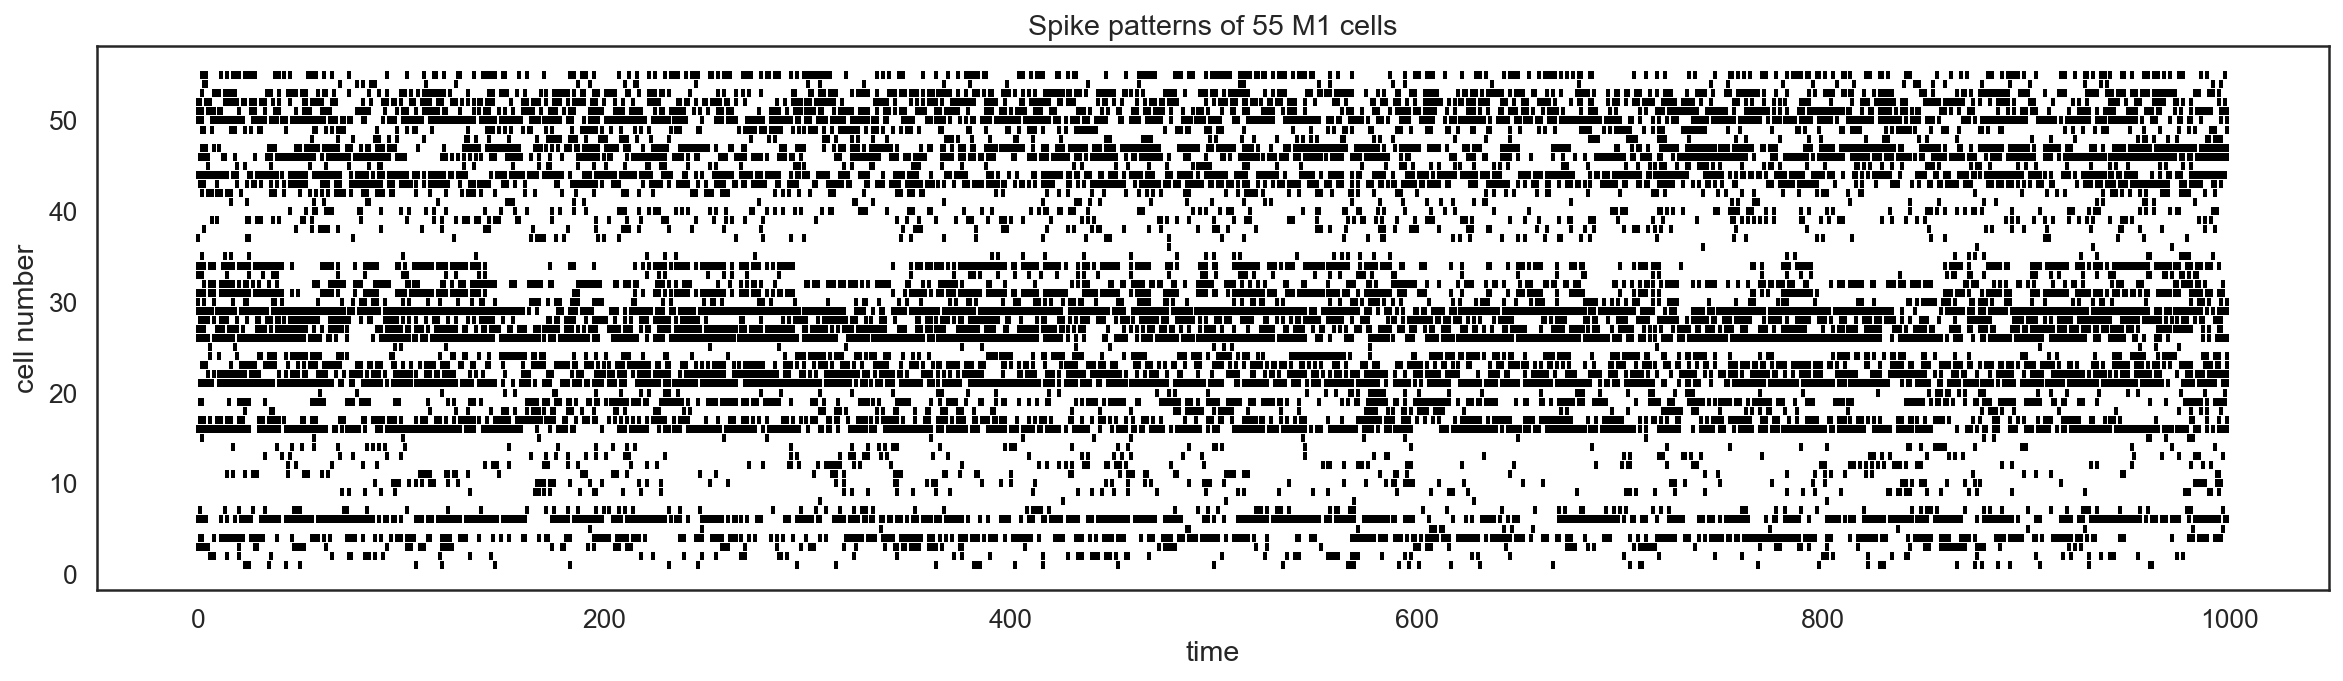

In [234]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))

# Convert patterns to zeros and ones
m1_binary_patterns = np.isin(m1_spatterns, range(1, 10)).astype(np.uint8) 

for i in range(m1_spatterns.shape[0]): 
    y_val = i + 1 
    pattern_i = m1_binary_patterns[i, :] * y_val
    pattern_i = [float('nan') if x==0 else x for x in pattern_i] 

    ax.scatter(range(m1_spatterns.shape[1]), pattern_i,  marker='|', c='k', s=20);
    ax.set_title(f'Spike patterns of {m1_spatterns.shape[0]} M1 cells')
    ax.set_xlabel('time')
    ax.set_ylabel('cell number')

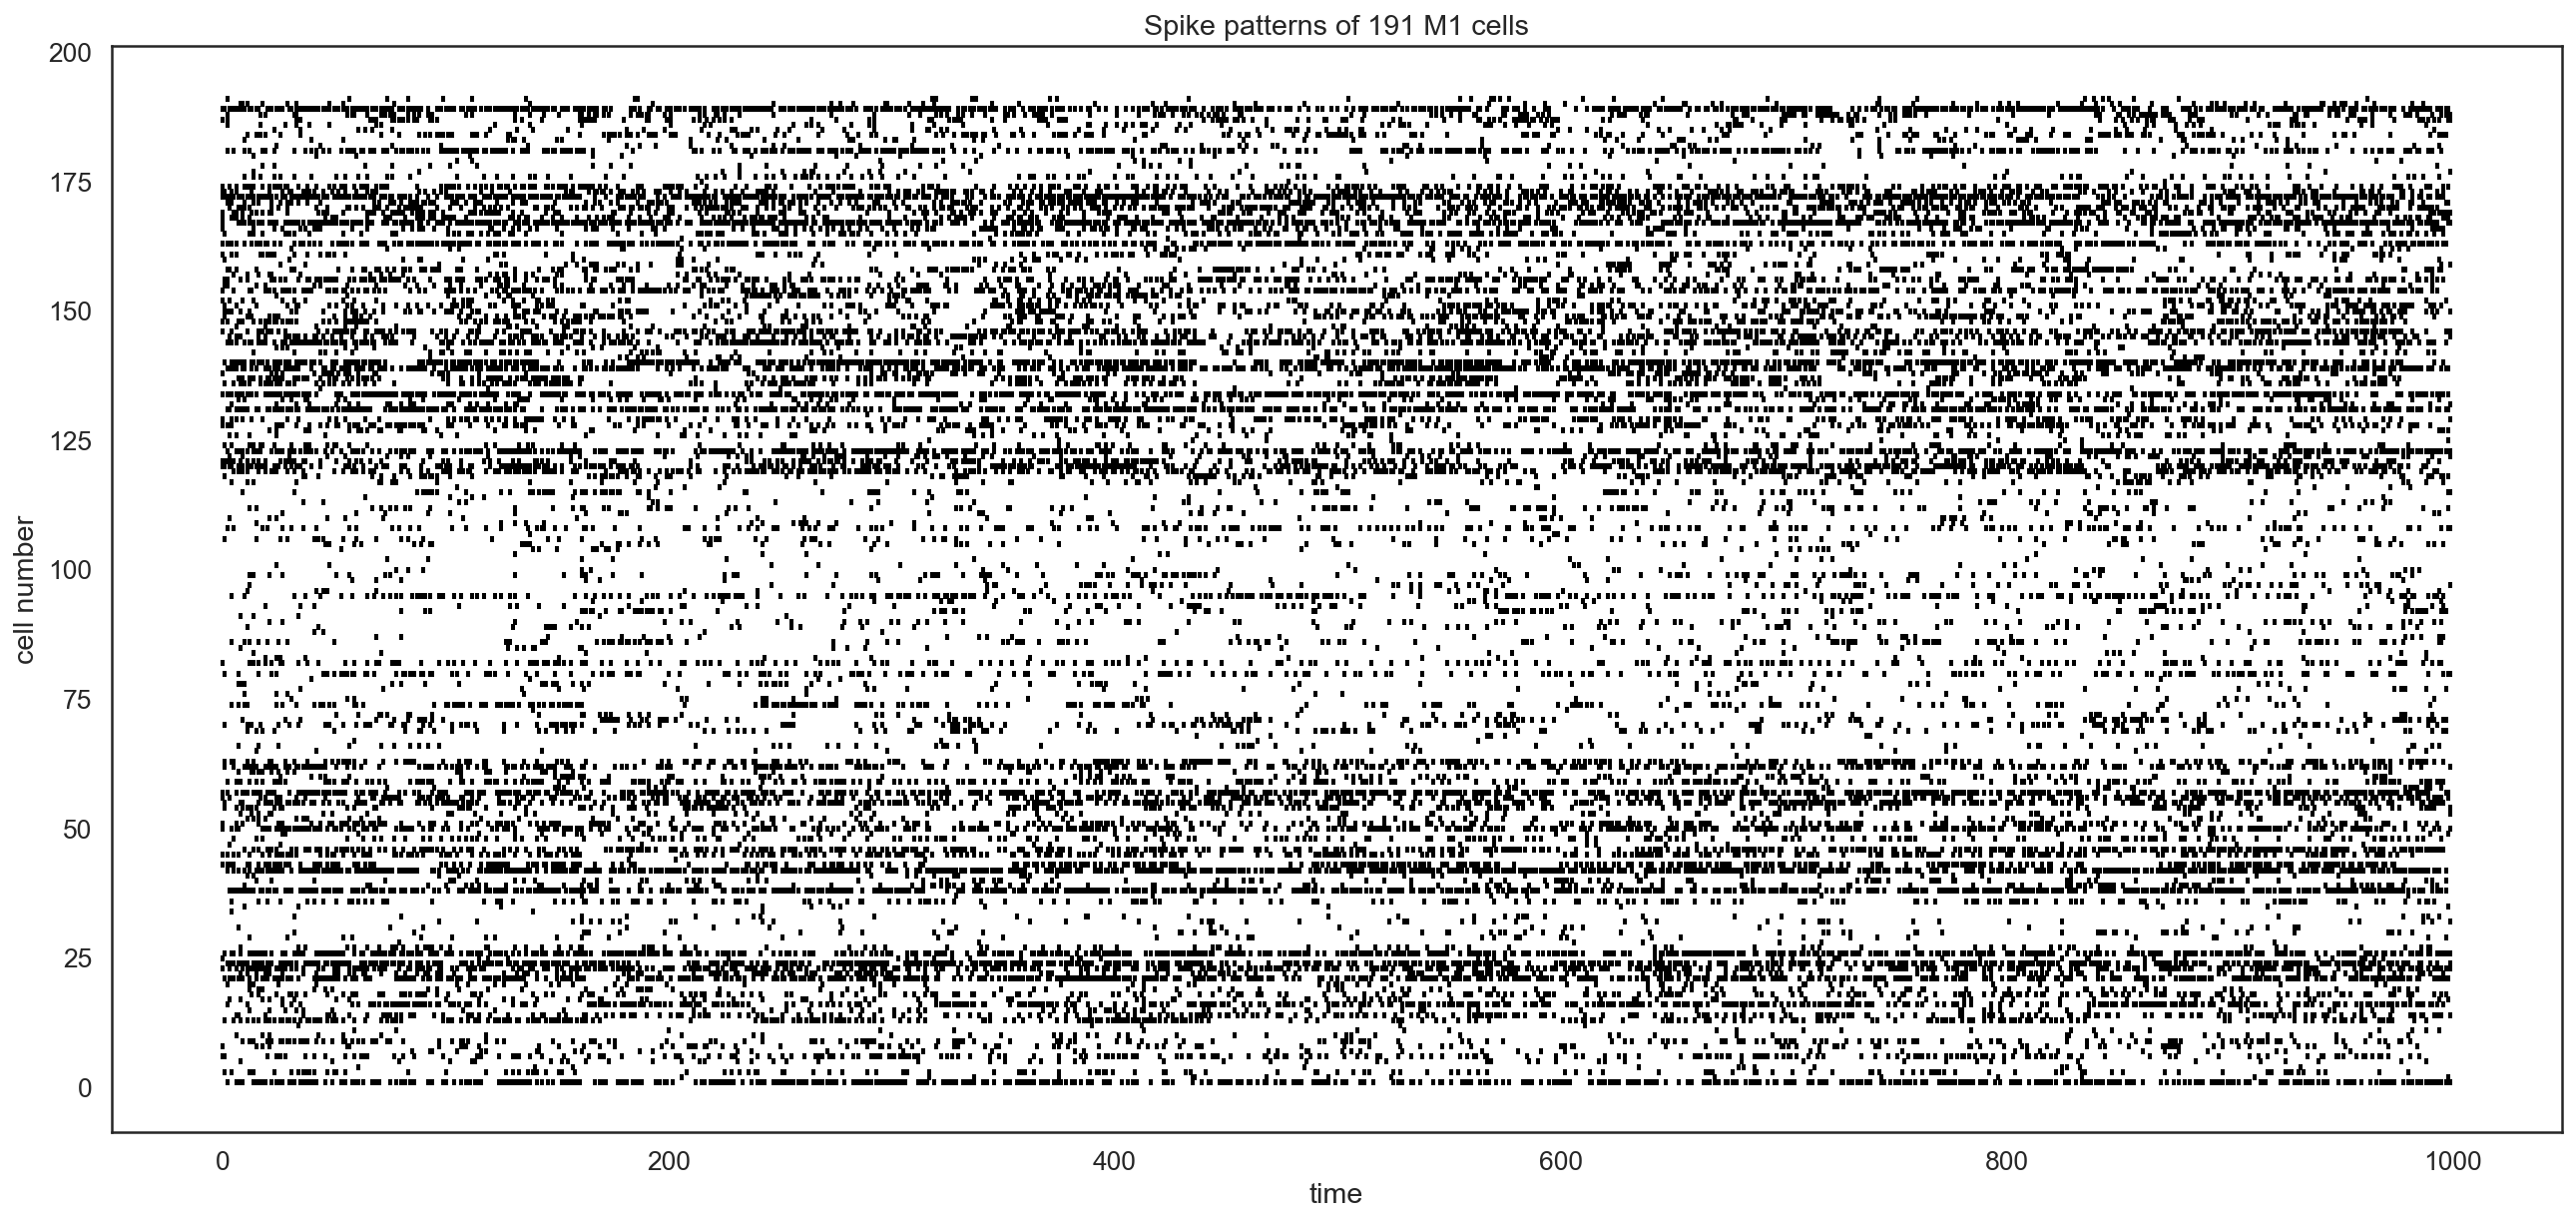

In [235]:
# Convert patterns to zeros and ones
pmd_binary_patterns = np.isin(pmd_spatterns, range(1, 10)).astype(np.uint8) 

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(22, 10))

for i in range(pmd_spatterns.shape[0]): 
    y_val = i + 1 
    pattern_i = pmd_binary_patterns[i, :] * y_val
    pattern_i = [float('nan') if x == 0 else x for x in pattern_i] 

    ax.scatter(range(pmd_spatterns.shape[1]), pattern_i,  marker='|', c='k', s=10);
    ax.set_title(f'Spike patterns of {pmd_spatterns.shape[0]} M1 cells')
    ax.set_xlabel('time')
    ax.set_ylabel('cell number')

### Compute the correlation (kendall) between spiking patterns and firing rates

In [213]:
# Get all the possible combinations between neuron pairs
neuron_pairs_all = list(itertools.combinations(range(X_emp_spikes.shape[1]), 2))
# Within arrays
neuron_pairs_m1  = list(itertools.combinations(range(td.M1_spikes[0].shape[1]), 2))
neuron_pairs_pmd = list(itertools.combinations(range(td.M1_spikes[0].shape[1], td.PMd_spikes[0].shape[1]), 2))

In [236]:
# For all neurons
spatterns_corrs = []
for i, j in pbar(neuron_pairs_all):
    tau, _ = stats.kendalltau(X_emp_spikes[i, :], X_emp_spikes[j, :])
    spatterns_corrs.append(tau)
    
rates_corrs = []
for i, j in pbar(neuron_pairs_all):
    tau, _ = stats.kendalltau(X_emp_rates[i, :], X_emp_rates[j, :])
    rates_corrs.append(tau)
    
# Correlations within arrays (expect this to be higher)
# Primary motor cortex (M1)
m1_spatterns_corrs = []
for i, j in pbar(neuron_pairs_m1):
    tau, _ = stats.kendalltau(X_emp_spikes[i, :], X_emp_spikes[j, :])
    m1_spatterns_corrs.append(tau)

m1_rates_corrs = []
for i, j in pbar(neuron_pairs_m1):
    tau, _ = stats.kendalltau(X_emp_rates[i, :], X_emp_rates[j, :])
    m1_rates_corrs.append(tau)
    
# Pre motor cortex (PMd)
pmd_spatterns_corrs = []
for i, j in pbar(neuron_pairs_pmd):
    tau, _ = stats.kendalltau(X_emp_spikes[i, :], X_emp_spikes[j, :])
    pmd_spatterns_corrs.append(tau)

pmd_rates_corrs = []
for i, j in pbar(neuron_pairs_pmd):
    tau, _ = stats.kendalltau(X_emp_rates[i, :], X_emp_rates[j, :])
    pmd_rates_corrs.append(tau)

100%|██████████| 9180/9180 [07:10<00:00, 21.31it/s]


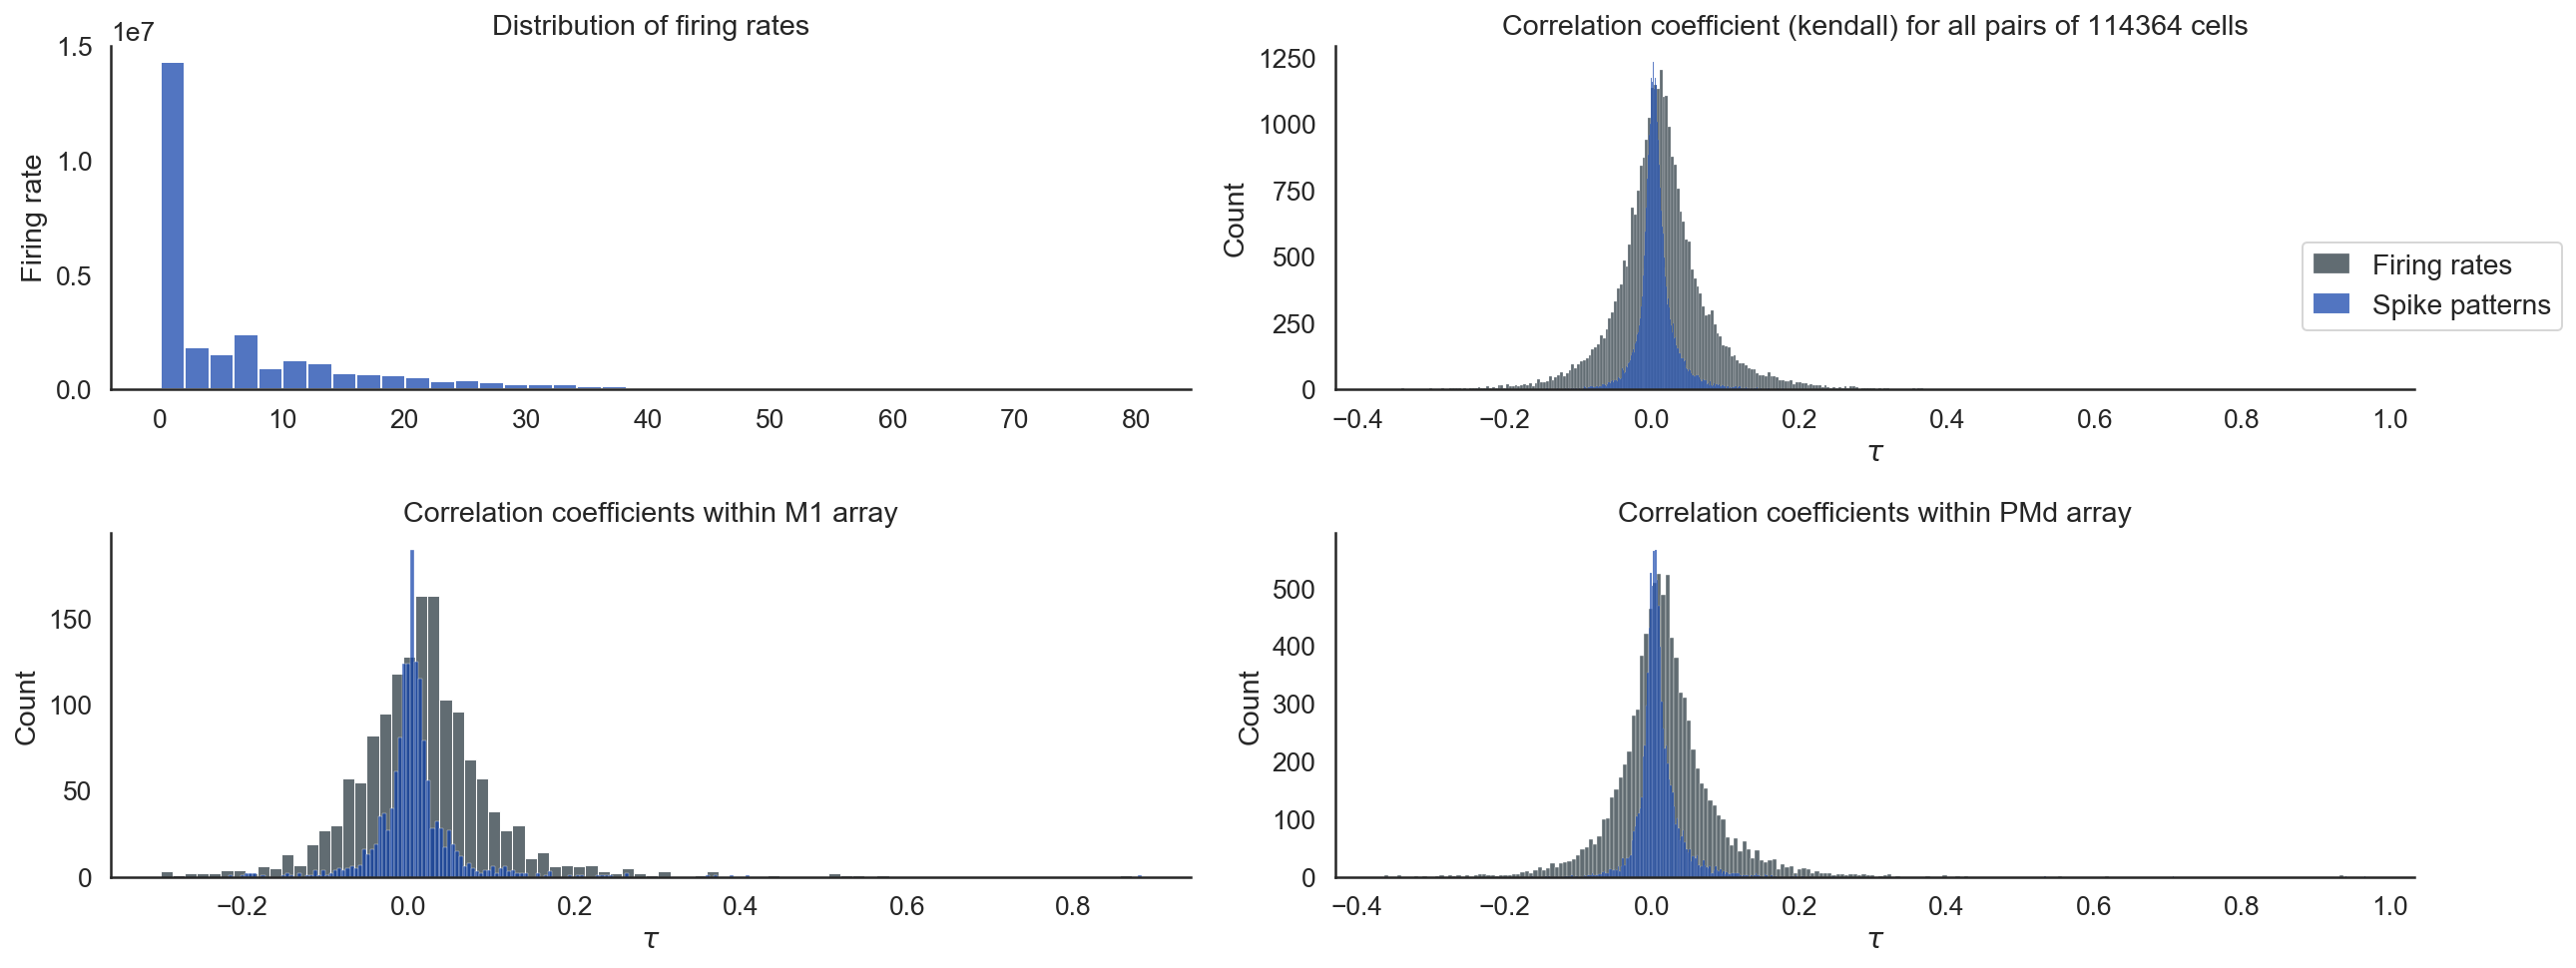

In [240]:
fig, axs = plt.subplots(2, 2, figsize=(18, 7))

axs[0, 0].set_title('Distribution of firing rates')
sns.histplot(X_emp_rates.flatten(), bins=40, alpha=0.7, ax=axs[0, 0])
axs[0, 0].set_ylabel('Firing rate')

axs[0, 1].set_title(f'Correlation coefficient (kendall) for all pairs of {X_emp_spikes.shape[1]} cells')
sns.histplot(rates_corrs, alpha=0.7, color=cs[1], ax=axs[0, 1], label='Firing rates')
sns.histplot(spatterns_corrs, alpha=0.7, color=cs[0], ax=axs[0, 1], label='Spike patterns')
# axs[0, 1].set_xticks(np.arange(0, 1, 0.1))
axs[0, 1].set_xlabel(r'$\tau$')

axs[1, 0].set_title(f'Correlation coefficients within M1 array')
sns.histplot(m1_rates_corrs, alpha=0.7, color=cs[1], ax=axs[1, 0])
sns.histplot(m1_spatterns_corrs, alpha=0.7, color=cs[0], ax=axs[1, 0])
# axs[1, 0].set_xticks(np.arange(0, 1, 0.1))
axs[1, 0].set_xlabel(r'$\tau$')

axs[1, 1].set_title(f'Correlation coefficients within PMd array')
sns.histplot(pmd_rates_corrs, alpha=0.7, color=cs[1], ax=axs[1, 1], label='Firing rates')
sns.histplot(pmd_spatterns_corrs, alpha=0.7, color=cs[0], ax=axs[1, 1], label='Spike patterns')
# axs[1, 1].set_xticks(np.arange(0, 1, 0.1))
axs[1, 1].set_xlabel(r'$\tau$')

axs[0, 1].legend(loc='center right', bbox_to_anchor=(1.15, 0.3))
plt.tight_layout()
sns.despine()

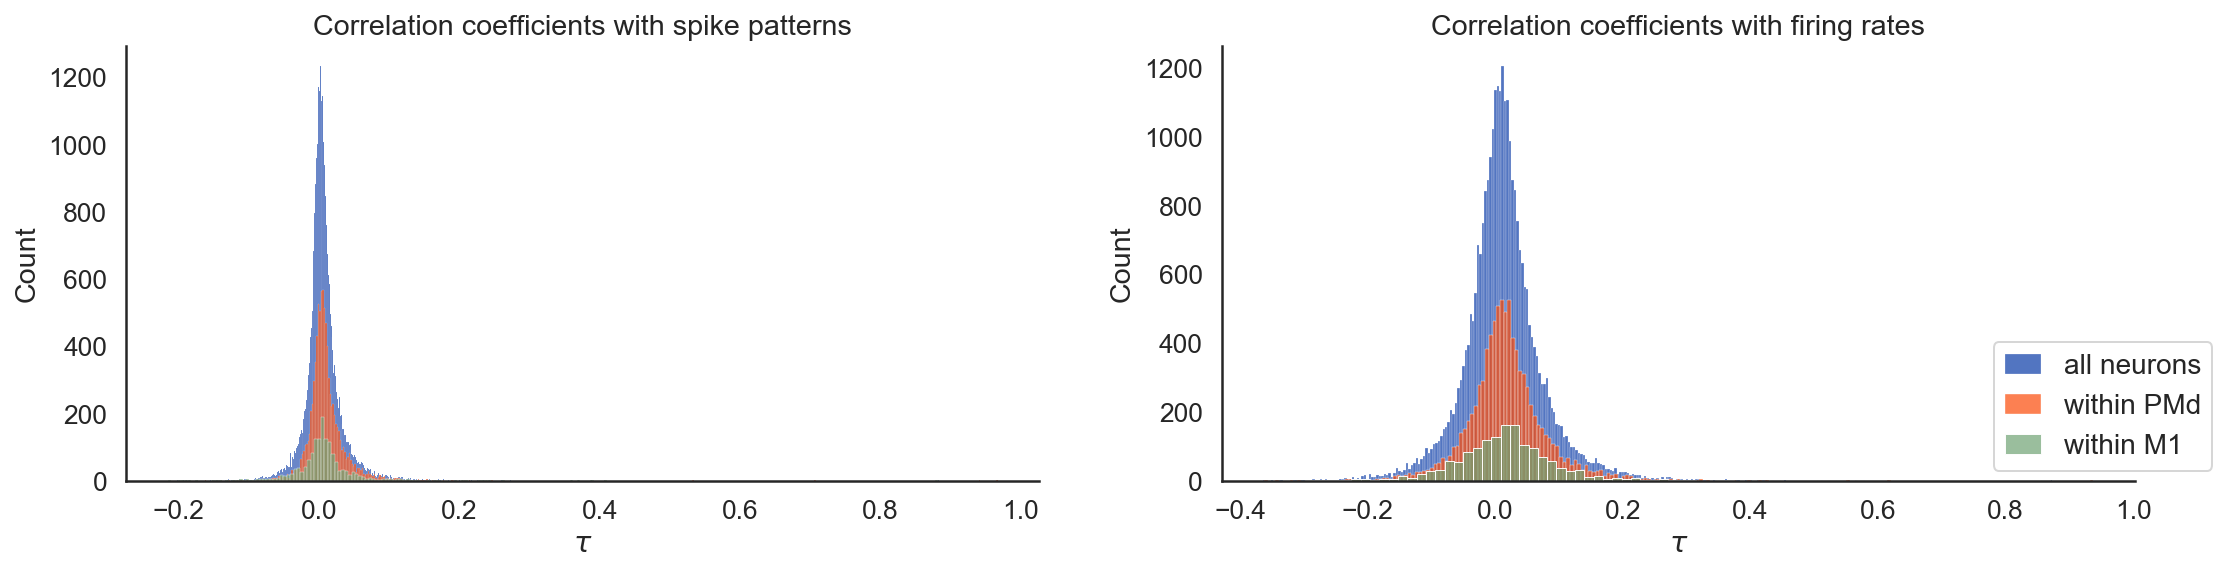

In [239]:
fig, axs = plt.subplots(1, 2, figsize=(18, 4))

axs[0].set_title(f'Correlation coefficients with spike patterns')
sns.histplot(spatterns_corrs, alpha=0.7,     color=cs[0], ax=axs[0], label='all neurons')
sns.histplot(pmd_spatterns_corrs, alpha=0.7, color=cs[4], ax=axs[0], label='within PMd')
sns.histplot(m1_spatterns_corrs, alpha=0.7,  color=cs[2], ax=axs[0], label='within M1')
# axs[0].set_xticks(np.arange(0, 1, 0.1))
axs[0].set_xlabel(r'$\tau$')

axs[1].set_title(f'Correlation coefficients with firing rates')
sns.histplot(rates_corrs, alpha=0.7, color=cs[0],     ax=axs[1], label='all neurons')
sns.histplot(pmd_rates_corrs, alpha=0.7, color=cs[4], ax=axs[1], label='within PMd')
sns.histplot(m1_rates_corrs, alpha=0.7, color=cs[2],  ax=axs[1], label='within M1')
# axs[1].set_xticks(np.arange(0, 1, 0.1))
axs[1].set_xlabel(r'$\tau$')

axs[1].legend(bbox_to_anchor=(1.1, 0.35))
sns.despine()

In [ ]:
# Color by distance/ firing rates.

### Correlate firing rates while preserving spatial location



In [244]:
N = td.both_spikes[0].shape[1] # Number of neurons

X_emp_rates.shape

(246, 114364)

In [246]:
R_emp = np.zeros((N, N))

for i in pbar(range(N)):
    for j in range(N):
        R_emp[i, j], _ = stats.pearsonr(X_emp_rates[i, :], X_emp_rates[j, :])

100%|██████████| 246/246 [19:09<00:00,  4.67s/it]


In [247]:
R_emp.shape

(246, 246)

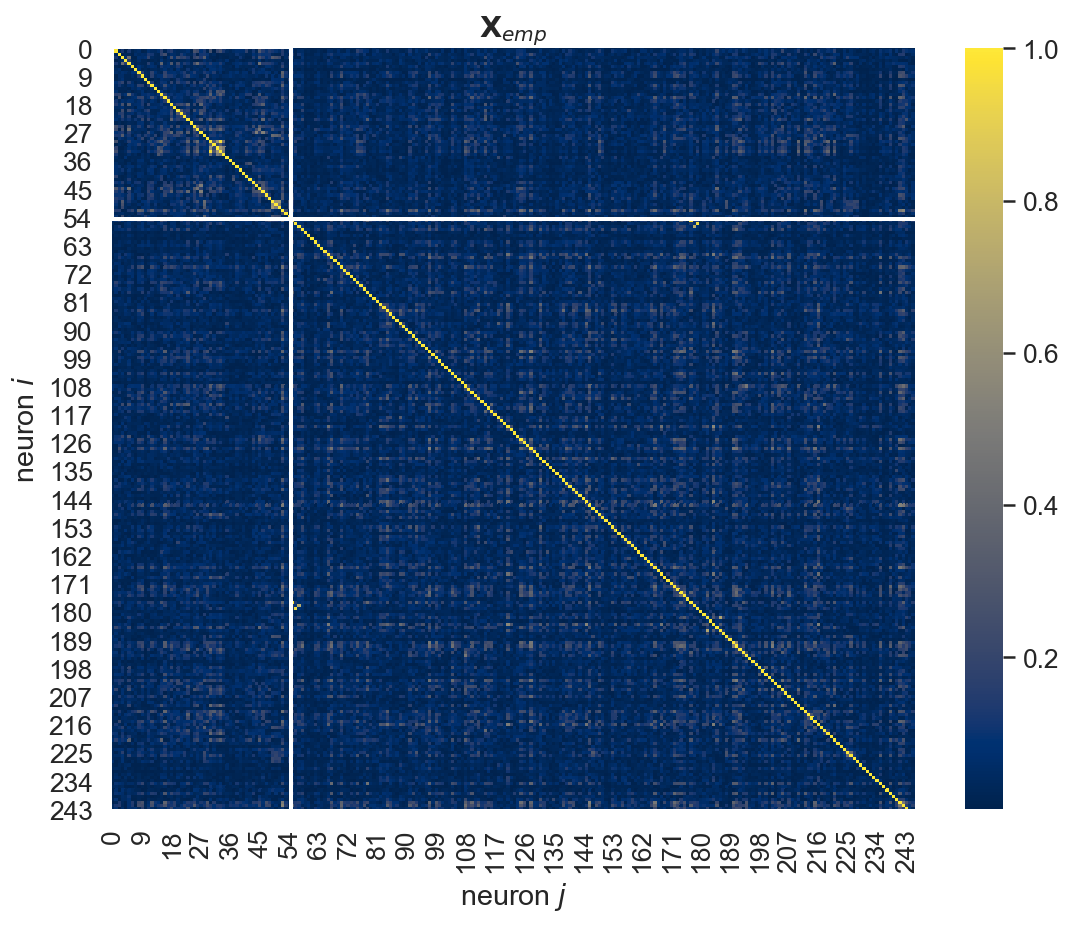

In [252]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 7))

ax.set_title(r'$\mathbf{X}_{emp}$')
sns.heatmap(abs(R_emp), cmap='cividis', ax=ax)
ax.set_xlabel(r'neuron $j$')
ax.set_ylabel(r'neuron $i$')

# Add white lines to indicate within and between array pc weights
ax.vlines([0], 0, td.M1_spikes[0].shape[1], colors='w', lw=2)
ax.hlines([0], 0, td.M1_spikes[0].shape[1], colors='w', lw=2)
ax.vlines([td.M1_spikes[0].shape[1]], 0, td.M1_spikes[0].shape[1]+td.PMd_spikes[0].shape[1], colors='w', lw=2)
ax.hlines([td.M1_spikes[0].shape[1]], 0, td.M1_spikes[0].shape[1]+td.PMd_spikes[0].shape[1], colors='w', lw=2);